In [2]:
import io
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

Total Ratings: 25000095
No of users who have rated the movie: 162541
No of Unique movies rated: 62423


<AxesSubplot:>

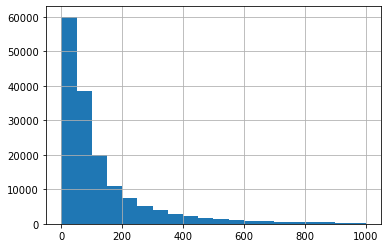

In [4]:
# number of ratings
print("Total Ratings:",len(ratings))

# number of users
print("No of users who have rated the movie:",len(ratings['userId'].unique()))

# number of unique movies (in movie list, not ratings)
print("No of Unique movies rated:",len(movies['movieId'].unique()))

# avg number of movie rated per user
ind_user_rating = ratings.groupby('userId')['rating'].count()
statistics.mean(ind_user_rating.tolist())

# distribution of ratings per user
# (we may want to exclude users without many data points)
%matplotlib inline
ind_user_rating.hist(bins=20, range=(0,1000))

<AxesSubplot:>

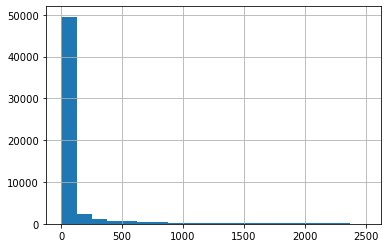

In [5]:
# avg number of ratings given per movie
ind_movie_ratings = ratings.groupby('movieId')['rating'].count()
statistics.mean(ind_movie_ratings.tolist())

# distribution of ratings per movie
%matplotlib inline
ind_movie_ratings.hist(bins=20, range=(0,2500))

In [8]:
# counts of ratings per movie
ind_movie_ratings_df = pd.DataFrame(ind_movie_ratings)
# remove if < 1000 ratings
filtered_ind_movie_ratings_df = ind_movie_ratings_df[ind_movie_ratings_df.rating >= 1000]
print(filtered_ind_movie_ratings_df )
# build a list of movieId
fam_movie = filtered_ind_movie_ratings_df.index.tolist()

         rating
movieId        
1         57309
2         24228
3         11804
4          2523
5         11714
...         ...
192389     1098
192803     2151
194448     1971
195159     3085
201773     1134

[3794 rows x 1 columns]


In [11]:
# counts ratings per user 
ind_user_ratings_df = pd.DataFrame(ind_movie_ratings)
# remove if < 500
filtered_ind_user_ratings_df = ind_user_ratings_df[ind_user_ratings_df.rating >= 500]
print(filtered_ind_user_ratings_df )
# build a list of user_ids to keep
fam_users = filtered_ind_user_ratings_df.index.tolist()

         rating
movieId        
1         57309
2         24228
3         11804
4          2523
5         11714
...         ...
197711      769
200818      733
201773     1134
202429      895
204698      818

[5386 rows x 1 columns]


In [13]:
filteredRatings = ratings[ratings.movieId.isin(fam_movie)]
filteredRatings = ratings[ratings.userId.isin(fam_users)]
len(filteredRatings)

802475

In [14]:
ratingMatrix = filteredRatings.pivot_table(index='userId', columns='movieId', values='rating')
# replace NaN values with 0
ratingMatrix = ratingMatrix.fillna(0)
# display the top few rows
ratingMatrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,207642,207656,207830,207890,208002,208341,208737,208889,208941,208955
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
def similarUsers(userId, matrix, k=3):
    # create a df of just the current user
    user = matrix[matrix.index == userId]
    
    # and a df of all other users
    otherUsers = matrix[matrix.index != userId]
    
    # calc cosine similarity between user and each other user
    similarities = cosine_similarity(user,otherUsers)[0].tolist()
    
    # create list of indices of these users
    indices = otherUsers.index.tolist()
    
    # create key/values pairs of user index and their similarity
    indexSimilarity = dict(zip(indices, similarities))
    
    # sort by similarity
    indexSimilaritySorted = sorted(indexSimilarity.items(), key=operator.itemgetter(1))
    indexSimilaritySorted.reverse()
    
    # grab k users off the top
    topUsers = indexSimilaritySorted[:k]
    Users = [user[0] for user in topUsers]
    
    return Users

In [22]:
import operator
def recommendItem(userIndex, similarUserIndices, matrix, items=10):
    
    # load vectors for similar users
    similarUsers = matrix[matrix.index.isin(similarUserIndices)]
    # calc avg ratings across the 3 similar users
    similarUsers = similarUsers.mean(axis=0)
    # convert to dataframe for sort and filter
    similarUsersDf = pd.DataFrame(similarUsers, columns=['mean'])
    
  
    # load vector for the current user
    userDf = matrix[matrix.index == userIndex]
    # transpose it so its easier to filter
    userDfTransposed = userDf.transpose()
    # rename the column as 'rating'
    userDfTransposed.columns = ['rating']
    # remove any rows without a 0 value. Movie not watched yet
    userDfTransposed = userDfTransposed[userDfTransposed['rating']==0]
    # generate a list of movies the user has not seen
    moviesUnseen = userDfTransposed.index.tolist()
    
    # filter avg ratings of similar users for only movie the current user has not seen
    similarUsersDfFiltered = similarUsersDf[similarUsersDf.index.isin(moviesUnseen)]
    # order the dataframe
    similarUsersDfOrdered = similarUsersDf.sort_values(by=['mean'], ascending=False)
    # grab the top n movie   
    topNmovie = similarUsersDfOrdered.head(items)
    topNmovieIndices = topNmovie.index.tolist()
    # lookup these movie in the other dataframe to find names
    movieInfo = movies[movies['movieId'].isin(topNmovieIndices)]
    
    return movieInfo #items

In [23]:
similarUserIndices = similarUsers(12, ratingMatrix)
print(similarUserIndices)
recommendItem(12, similarUserIndices, ratingMatrix)

[5470, 3937, 3274]


,movieId,title,genres
522,527,Schindler's List (1993),Drama|War
545,551,"Nightmare Before Christmas, The (1993)",Animation|Children|Fantasy|Musical
600,608,Fargo (1996),Comedy|Crime|Drama|Thriller
1108,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
1164,1193,One Flew Over the Cuckoo's Nest (1975),Drama
1237,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi
1559,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller
2766,2858,American Beauty (1999),Drama|Romance
3794,3897,Almost Famous (2000),Drama
7028,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
